In [1]:
import numpy as np
from LightTools import LTAPIx
import time
import matplotlib.pyplot as plt
import re
PID = 14324
loc = LTAPIx.LTLocator()
lt = loc.GetLTAPIFromPID(PID)
lt.Message('Script LT connection established')

0

In [28]:
class Zone:
    def __init__(self, name, shape_type, shape_paras, opt_type, opt_paras) -> None:
        self.name = name
        self.shape_type = shape_type        
        self.shape_paras = shape_paras
        self.opt_type = opt_type
        self.opt_paras = opt_paras
        if shape_type == 'Polygonal':
            self.shape_paras_LT = {**{'X_Offset':0, 'Y_Offset':0, 'Theta_Rotation':0}, **self.array_to_dict(shape_paras, 'Vertex_X_At', 'Vertex_Y_At')}
        elif shape_type == 'Circle':
            self.shape_paras_LT = {'X_Offset':shape_paras[0], 'Y_Offset':shape_paras[1], 'Theta_Rotation':0, 'Radius':shape_paras[2]}
        else:
            raise NameError('Only Polygonal and Circle are allowed')
        return
    
    def check_tabulated(self, s):
        # Use regex to find a number inside square brackets
        match = re.search(r'([^\[]+)\[(\d+)\]', s)
        if match:
            text_before_bracket = match.group(1)  # Extract the text before the bracket
            number_in_bracket = int(match.group(2))  # Extract the number inside the bracket as an integer
            return text_before_bracket, number_in_bracket
        return s, None  # Return None if the pattern isn't found

    def array_to_dict(self, input_array, *labels):
        output_dict = {}
        label_list = list(labels)
        num_columns = input_array.shape[1]
        if len(label_list) != num_columns:
            raise ValueError(f"Number of labels ({len(label_list)}) must match the number of columns ({num_columns}) in the input array.")
        for i, row in enumerate(input_array, start=1):
            for j in range(num_columns):
                output_dict[f"{label_list[j]}[{i}]"] = row[j]
        return output_dict

    def set_zone(self, lt, surface_key, name, shape, paras):
        lt.Cmd("\O" + lt.Str(surface_key))
        lt.Cmd(lt.Str("Add Property Zone"))
        lt.Cmd("\Q")
        lt.DbSet(f'{surface_key}.ZONE[@Last]','Name', f'{name}')
        lt.DbSet(f'{surface_key}.ZONE[{name}].RECT_ZONE_EXTENT[RectangularZone]', 'Element Shape', shape) 
        shape_keys = {'Circle':'CIRC_ZONE_EXTENT[CircularZone]', 'Polygonal':'POLYGON_ZONE_EXTENT[PolygonalZone]'}
        lt.SetOption("DbUpdate", 0)
        for k_str in paras.keys():        
            k, ind = self.check_tabulated(k_str)
            if  ind is not None:
                # print(k, ind, lt.DbGet(f'PROPERTY_MANAGER[Optical Properties Manager].PROPERTY[{name}].{f}', k, None, ind))
                lt.DbSet(f'{surface_key}.ZONE[{name}].{shape_keys[shape]}', k, paras[k_str], ind)
            else:                
                # print(k, lt.DbGet(f'PROPERTY_MANAGER[Optical Properties Manager].PROPERTY[{name}].{f}', k))
                lt.DbSet(f'{surface_key}.ZONE[{name}].{shape_keys[shape]}', k, paras[k_str])    
        
        lt.Cmd("\O" + lt.Str(f'{surface_key}.ZONE[{name}]'))
        lt.Cmd("PropertyName=" + f'"{name}"')
        lt.Cmd("\Q")        
        lt.SetOption("DbUpdate", 1)

    def add_zone_property(self, lt, name, opt_type, paras):
        lt.Cmd("\O" + lt.Str('PROPERTY_MANAGER[Optical Properties Manager]'))
        lt.Cmd("AddNew=""")
        lt.Cmd("\Q")
        lt.DbSet('PROPERTY_MANAGER[Optical Properties Manager].PROPERTY[@Last]','Name', f'{name}')
        lt.DbSet(f'PROPERTY_MANAGER[Optical Properties Manager].PROPERTY[{name}]', 'Simple Type', opt_type)    
        lt.SetOption("DbUpdate", 0)
        if paras is not None:
            for f in paras.keys():
                for k_str in paras[f].keys():
                    # lt.DbSet(f'PROPERTY_MANAGER[Optical Properties Manager].PROPERTY[{name}].{f}', k, paras[f][k])
                    k, ind = self.check_tabulated(k_str)
                    if  ind is not None:
                        # print(k, ind, lt.DbGet(f'PROPERTY_MANAGER[Optical Properties Manager].PROPERTY[{name}].{f}', k, None, ind))
                        lt.DbSet(f'PROPERTY_MANAGER[Optical Properties Manager].PROPERTY[{name}].{f}', k, paras[f][k_str], ind)
                    else:                
                        # print(k, lt.DbGet(f'PROPERTY_MANAGER[Optical Properties Manager].PROPERTY[{name}].{f}', k))
                        lt.DbSet(f'PROPERTY_MANAGER[Optical Properties Manager].PROPERTY[{name}].{f}', k, paras[f][k_str])
        lt.SetOption("DbUpdate", 1)


    def to_LT(self, lt, surface_key):
        self.add_zone_property(lt, self.name, self.opt_type, self.opt_paras)
        self.set_zone(lt, surface_key, self.name, self.shape_type, self.shape_paras_LT)
        return
    


In [3]:
# Optical Property Parameters
paras_1 = {'RULED_DOE_DIRECTION_ZONE[RuledGrating]':{'Grating_Period':0.0005, 'Blaze_Type': 'Manual', 'Grating_Vector_X':0, 'Grating_Vector_Y':1, 'Grating_Vector_Z':0},
           'DIFFRACTION_EFFICIENCY_ZONE[diffEffTable]':{'Minimum_Order':0, 'Maximum_Order':1, 'EnabledTransmittedOrderAt[1]':0, 'ReflectedEfficiencyAt[1]':0.9, 'EnabledTransmittedOrderAt[2]':0, 
                                                        'ReflectedEfficiencyAt[2]':0.1, 'TransmittedEfficiencyAt[1]':0, 'TransmittedEfficiencyAt[2]':0}
           }

paras_2 = {'RULED_DOE_DIRECTION_ZONE[RuledGrating]':{'Grating_Period':0.0005, 'Blaze_Type': 'Manual', 'Grating_Vector_X':1, 'Grating_Vector_Y':0, 'Grating_Vector_Z':0},
           'DIFFRACTION_EFFICIENCY_ZONE[diffEffTable]':{'Minimum_Order':0, 'Maximum_Order':1, 'EnabledTransmittedOrderAt[1]':0, 'ReflectedEfficiencyAt[1]':0.8, 'EnabledTransmittedOrderAt[2]':0, 
                                                        'ReflectedEfficiencyAt[2]':0.2, 'TransmittedEfficiencyAt[1]':0, 'TransmittedEfficiencyAt[2]':0}
           }

In [29]:
surface_key = 'LENS_MANAGER[1].COMPONENTS[Components].SOLID[Cylinder_3].CYLINDER_PRIMITIVE[CylinderPrimitive_1].PLANAR_SURFACE[FrontSurface]'


epe_shape_pts = np.loadtxt('EPE.txt')
oc_shape_pts = np.loadtxt('oc.txt')


ic = Zone('IC', 'Circle', (-41.89725171, 29.00955127, 1.5), 'Linear Grating', None)
epe = Zone('EPE', 'Polygonal', epe_shape_pts, 'Measured BSDF', None)
oc = Zone('OC', 'Polygonal', oc_shape_pts, 'RSoft BSDF UDOP', None)



In [30]:
ic.to_LT(lt, surface_key)
epe.to_LT(lt, surface_key)
oc.to_LT(lt, surface_key)

In [14]:
name = 'IC'
print(f'PropertyName="{name}"')

PropertyName="IC"


In [3]:

import numpy as np
canvas_width = 1600
canvas_height = 1200
grid_size = 100
canvas_dimension = np.array([canvas_width, canvas_height])
grid_line_num = np.array([int(canvas_width / grid_size) + 1, int(canvas_height / grid_size) + 1])
grid_line_start_pos = ((canvas_dimension - (grid_line_num - 1) * grid_size) * 0.5).astype(int)

In [6]:
from functools import partial

class MyClass:
    def __init__(self, custom_test_a=None):
        if custom_test_a:
            # Create a bound version of the custom function to automatically include `self`
            self.test_a = lambda: custom_test_a(self)
        else:
            # Use the default method if no custom function is provided
            self.test_a = self.default_test_a

    def default_test_a(self):
        print("Default test_a method content")

    def other_method(self):
        print("This is another method in MyClass")

# User-defined function that takes additional parameters
def user_defined_test_a(self, param1, param2):
    print(f"User-defined test_a method content with param1: {param1} and param2: {param2}")
    self.other_method()  # Access another method

# Fix the parameters using partial
custom_func = partial(user_defined_test_a, param1="Hello", param2="World")

# Example usage
obj = MyClass(custom_test_a=custom_func)
obj.test_a()  # Now you can call `test_a()` without explicitly passing `self`


User-defined test_a method content with param1: Hello and param2: World
This is another method in MyClass


In [7]:
class CustomFunctionWrapper:
    def __init__(self, func, **initial_params):
        self.func = func
        self.params = initial_params

    def set_params(self, **new_params):
        """Adjust parameters as needed"""
        self.params.update(new_params)

    def __call__(self, instance):
        """Invoke the wrapped function with the given instance and stored parameters"""
        self.func(instance, **self.params)


class MyClass:
    def __init__(self, custom_test_a=None):
        if custom_test_a:
            # If custom function is provided, set it as test_a
            self.test_a = lambda: custom_test_a(self)
        else:
            # Use the default method if no custom function is provided
            self.test_a = self.default_test_a

    def default_test_a(self):
        print("Default test_a method content")

    def other_method(self):
        print("This is another method in MyClass")

# User-defined function that takes additional parameters
def user_defined_test_a(self, param1, param2):
    print(f"User-defined test_a method content with param1: {param1} and param2: {param2}")
    self.other_method()  # Access another method

# Wrap the user-defined function in CustomFunctionWrapper with initial parameters
wrapped_func = CustomFunctionWrapper(user_defined_test_a, param1="Initial", param2="Parameters")

# Example usage
obj = MyClass(custom_test_a=wrapped_func)
obj.test_a()  # Calls the user-defined function with initial parameters

# Adjust parameters afterwards
wrapped_func.set_params(param1="Updated", param2="Values")
obj.test_a()  # Calls the user-defined function with updated parameters


User-defined test_a method content with param1: Initial and param2: Parameters
This is another method in MyClass
User-defined test_a method content with param1: Updated and param2: Values
This is another method in MyClass


In [2]:
import json

sys_params = [
    {'label': 'Wavelength (R/G/B)', 'value': '650 / 550 / 450', 'static': False},
    {'label': 'Field of View (H/V)', 'value': '30 / 30', 'static': False},
    {'label': 'Diagonal FOV', 'value': '42.4264', 'static': False},
    {'label': 'Eye Relief (mm)', 'value': '15', 'static': False},
    {'label': 'Eyebox (W/H)', 'value': '20 / 20', 'static': False},
    {'label': 'OC Area (W/H)', 'value': '30 / 30', 'static': False},
    {'label': 'Substrate RI', 'value': '1.7', 'static': False},
    {'label': 'Ambient RI', 'value': '1', 'static': False}
]

grating_params_ic = [
    {'label': 'Grating Pitch', 'value': '309.6603', 'static': False},
    {'label': 'Grating Vector Angle', 'value': '-80.9995', 'static': False},
    {'label': 'Grating Vector Length (R/G/B)', 'value': '2.0991 / 1.7761 / 1.4532', 'static': False},
    {'label': 'Light Traversal Angle', 'value': '-80.9995', 'static': False}
]

grating_params_epe = [
    {'label': 'Grating Pitch', 'value': '220.9468', 'static': False},
    {'label': 'Grating Vector Angle', 'value': '53.2507', 'static': False},
    {'label': 'Grating Vector Length (R/G/B)', 'value': '2.9419 / 2.4893 / 2.0367', 'static': False},
    {'label': 'Light Traversal Angle', 'value': '7.7432', 'static': False}
]

grating_params_oc = [
    {'label': 'Grating Pitch', 'value': '308.3817', 'static': False},
    {'label': 'Grating Vector Angle', 'value': '-172.2568', 'static': False},
    {'label': 'Grating Vector Length (R/G/B)', 'value': '2.1078 / 1.7835 / 1.4592', 'static': False}
]


with open('sys_params.json', 'w') as f:
    json.dump(sys_params, f)

grating_types = ['ic', 'epe', 'oc']
grating_params = [grating_params_ic, grating_params_epe, grating_params_oc]

for i, t in enumerate(grating_types):
    with open(f'grating_params_{t}.json', 'w') as f:
        json.dump(grating_params[i], f)

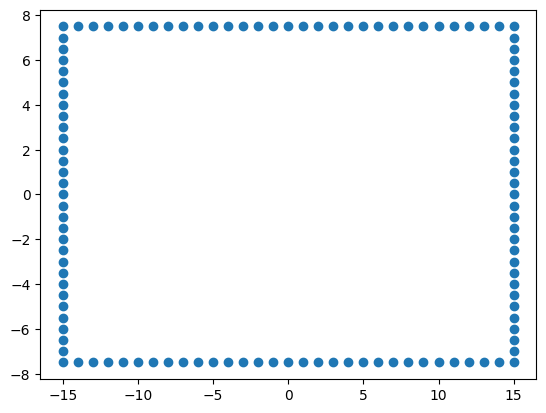

In [10]:
import numpy as np
import matplotlib.pyplot as plt


def get_outermost_points(x, y):
    """
    Get the outermost grid points from two 1D coordinate arrays.

    Parameters:
        x (numpy.ndarray): 1D array of x-coordinates.
        y (numpy.ndarray): 1D array of y-coordinates.

    Returns:
        numpy.ndarray: 2D array of outermost (x, y) points.
    """
    # Top and bottom rows (vary x, y fixed at min and max)
    top_bottom_x = np.concatenate([x, x])  # x varies
    top_bottom_y = np.concatenate([np.full_like(x, y[0]), np.full_like(x, y[-1])])  # y is fixed

    # Left and right columns (vary y, x fixed at min and max)
    left_right_x = np.concatenate([np.full_like(y[1:-1], x[0]), np.full_like(y[1:-1], x[-1])])  # x is fixed
    left_right_y = np.concatenate([y[1:-1], y[1:-1]])  # y varies

    # Combine all points
    outer_x = np.concatenate([top_bottom_x, left_right_x])
    outer_y = np.concatenate([top_bottom_y, left_right_y])

    # Combine into (x, y) pairs
    return np.column_stack((outer_x, outer_y))

hfov = 30
vfov = 15
angle_step = 1

num = int((hfov / angle_step)) + 1
hfov_pts = np.linspace(-0.5 * hfov, 0.5 * hfov, num)
vfov_pts = np.linspace(-0.5 * vfov, 0.5 * vfov, num)
vertices = get_outermost_points(hfov_pts, vfov_pts)
# vertices = np.squeeze(np.dstack([hfov_pts, vfov_pts]))
# print(vertices.shape)
plt.scatter(vertices[:, 0], vertices[:, 1])

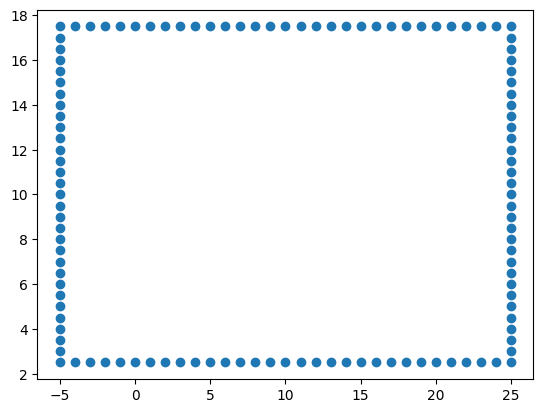

In [11]:
center = np.array([10, 10])
vertices += center
plt.scatter(vertices[:, 0], vertices[:, 1])

In [9]:
import numpy as np

# Create a meshgrid
x = np.linspace(0, 4, 5)  # x-coordinates
y = np.linspace(0, 4, 5)  # y-coordinates
X, Y = np.meshgrid(x, y)

# Select the outermost grid points
outer_x = np.concatenate([X[0, :],  # Top row
                          X[-1, :],  # Bottom row
                          X[1:-1, 0],  # Left column (excluding corners)
                          X[1:-1, -1]])  # Right column (excluding corners)

outer_y = np.concatenate([Y[0, :],  # Top row
                          Y[-1, :],  # Bottom row
                          Y[1:-1, 0],  # Left column (excluding corners)
                          Y[1:-1, -1]])  # Right column (excluding corners)

# Combine into a single array of coordinates
outer_points = np.column_stack((outer_x, outer_y))

# Print results
print("Outermost grid points (x, y):")
print(outer_points)


Outermost grid points (x, y):
[[0. 0.]
 [1. 0.]
 [2. 0.]
 [3. 0.]
 [4. 0.]
 [0. 4.]
 [1. 4.]
 [2. 4.]
 [3. 4.]
 [4. 4.]
 [0. 1.]
 [0. 2.]
 [0. 3.]
 [4. 1.]
 [4. 2.]
 [4. 3.]]


In [5]:
vertices += np.array([100, 0])
print(vertices)

[[ 85.    -7.5 ]
 [ 85.5   -7.25]
 [ 86.    -7.  ]
 [ 86.5   -6.75]
 [ 87.    -6.5 ]
 [ 87.5   -6.25]
 [ 88.    -6.  ]
 [ 88.5   -5.75]
 [ 89.    -5.5 ]
 [ 89.5   -5.25]
 [ 90.    -5.  ]
 [ 90.5   -4.75]
 [ 91.    -4.5 ]
 [ 91.5   -4.25]
 [ 92.    -4.  ]
 [ 92.5   -3.75]
 [ 93.    -3.5 ]
 [ 93.5   -3.25]
 [ 94.    -3.  ]
 [ 94.5   -2.75]
 [ 95.    -2.5 ]
 [ 95.5   -2.25]
 [ 96.    -2.  ]
 [ 96.5   -1.75]
 [ 97.    -1.5 ]
 [ 97.5   -1.25]
 [ 98.    -1.  ]
 [ 98.5   -0.75]
 [ 99.    -0.5 ]
 [ 99.5   -0.25]
 [100.     0.  ]
 [100.5    0.25]
 [101.     0.5 ]
 [101.5    0.75]
 [102.     1.  ]
 [102.5    1.25]
 [103.     1.5 ]
 [103.5    1.75]
 [104.     2.  ]
 [104.5    2.25]
 [105.     2.5 ]
 [105.5    2.75]
 [106.     3.  ]
 [106.5    3.25]
 [107.     3.5 ]
 [107.5    3.75]
 [108.     4.  ]
 [108.5    4.25]
 [109.     4.5 ]
 [109.5    4.75]
 [110.     5.  ]
 [110.5    5.25]
 [111.     5.5 ]
 [111.5    5.75]
 [112.     6.  ]
 [112.5    6.25]
 [113.     6.5 ]
 [113.5    6.75]
 [114.     7. 

In [19]:
import re

def test_regex(input_string, regex_pattern):
    """
    Test if an input string matches the given regex pattern.

    Parameters:
    - input_string (str): The string to test.
    - regex_pattern (str): The regex pattern to match.

    Returns:
    - bool: True if the input string matches the regex pattern, False otherwise.
    """
    return bool(re.fullmatch(regex_pattern, input_string))

# Example Usage
input_strings = ["123.4568 / 550.0 / 450", '0 / 0/ 0', '010', '000/100/010', '100/200/10']
regex_pattern = r"^[1-9]\d*(\.\d+)?\s*\/\s*[1-9]\d*(\.\d+)?\s*\/\s*[1-9]\d*(\.\d+)?$"

# Test
for s in input_strings:
    result = test_regex(s, regex_pattern)
    print(f"Does the input {s} match the regex? {result}")


Does the input 123.4568 / 550.0 / 450 match the regex? True
Does the input 0 / 0/ 0 match the regex? False
Does the input 010 match the regex? False
Does the input 000/100/010 match the regex? False
Does the input 100/200/10 match the regex? True


In [23]:
a = '30/30'
c, d = [float(x) for x in a.split('/')]
print(c, d)

30.0 30.0
